## Connect Google Drive to Colab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install super-gradients library

In [3]:
!pip install super-gradients

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 964.2/964.2 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 54.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 99.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 110.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 44.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 110.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 

## Libraries Importation

In [1]:
# Libraries Importation

from super_gradients.training import Trainer
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, 
    coco_detection_yolo_format_val
)
from super_gradients.training import models
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import (
    DetectionMetrics_050,
    DetectionMetrics_050_095
)
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback
from tqdm.auto import tqdm
 
import os
import requests
import zipfile
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import random

The console stream is logged into /root/sg_logs/console.log


[2023-06-01 03:07:18] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it
/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-06-01 03:07:27] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-06-01 03:07:27] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-06-01 03:07:27] WARNING - export.py - Failed to import pytorch_quantization
[2023-06-01 03:07:27] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization


## Parameters Setting

In [15]:
ROOT_DIR = '/content/drive/MyDrive/yolonas/dataset'
train_imgs_dir = 'images/train'
train_labels_dir = 'labels/train'
val_imgs_dir = 'images/val'
val_labels_dir = 'labels/val'
test_imgs_dir = 'images/test'
test_labels_dir = 'labels/test'
classes = ['damaged ', 'intact']
 
dataset_params = {
    'data_dir':ROOT_DIR,
    'train_images_dir':train_imgs_dir,
    'train_labels_dir':train_labels_dir,
    'val_images_dir':val_imgs_dir,
    'val_labels_dir':val_labels_dir,
    'test_images_dir':test_imgs_dir,
    'test_labels_dir':test_labels_dir,
    'classes':classes 
}

In [4]:
# Global parameters.
EPOCHS = 10
BATCH_SIZE = 16
WORKERS = 8

In [20]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)
 
val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

test_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['test_images_dir'],
        'labels_dir': dataset_params['test_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':BATCH_SIZE,
        'num_workers':WORKERS
    }
)

Caching annotations: 100%|██████████| 17/17 [00:00<00:00, 352.89it/s]


In [21]:
# Check data transformation types

train_data.dataset.transforms

[DetectionMosaic('additional_samples_count': 3, 'non_empty_targets': False, 'prob': 1.0, 'input_dim': [640, 640], 'enable_mosaic': True, 'border_value': 114),
 DetectionRandomAffine('additional_samples_count': 0, 'non_empty_targets': False, 'degrees': 10.0, 'translate': 0.1, 'scale': [0.1, 2], 'shear': 2.0, 'target_size': [640, 640], 'enable': True, 'filter_box_candidates': True, 'wh_thr': 2, 'ar_thr': 20, 'area_thr': 0.1, 'border_value': 114),
 DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114),
 DetectionHSV('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 1.0, 'hgain': 5, 'sgain': 30, 'vgain': 30, 'bgr_channels': (0, 1, 2), '_additional_channels_warned': False),
 DetectionHorizontalFlip('additional_samples_count': 0, 'non_empty_targets': False, 'prob': 0.5, 'max_targets': 120),
 DetectionPaddedRescale('swap': (2, 0, 1),

In [22]:
# An example on how to modify above data augmentation parameters

train_data.dataset.transforms.pop(2)

DetectionMixup('additional_samples_count': 1, 'non_empty_targets': True, 'input_dim': [640, 640], 'mixup_scale': [0.5, 1.5], 'prob': 1.0, 'enable_mixup': True, 'flip_prob': 0.5, 'border_value': 114)

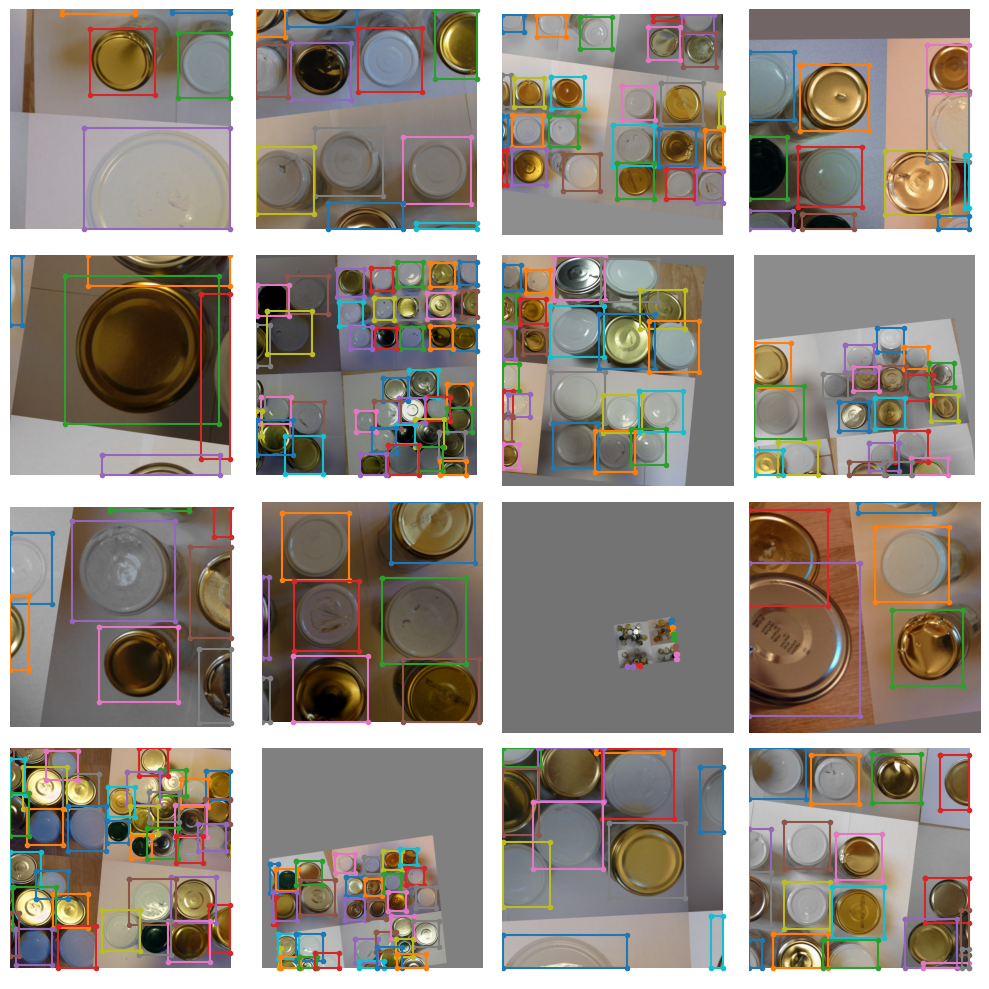

In [23]:
# Visualize the transformed images

train_data.dataset.plot(plot_transformed_data=True)


## YOLO NAS Training Parameters

In [25]:
EPOCHS = 50
train_params = {
    'silent_mode': False,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    "max_epochs": EPOCHS,
    "mixed_precision": False,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        ),
        DetectionMetrics_050_095(
            score_thres=0.1,
            top_k_predictions=300,
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50:0.95'
}

## YOLO NAS Model Training

In [26]:
"""
models_to_train = [
    'yolo_nas_s',
    'yolo_nas_m',
    'yolo_nas_l'
]
 """
 
models_to_train = [
    'yolo_nas_s'
]
CHECKPOINT_DIR = '/content/drive/MyDrive/yolonas/checkpoints'
 
for model_to_train in models_to_train:
    trainer = Trainer(
        experiment_name=model_to_train, 
        ckpt_root_dir=CHECKPOINT_DIR
    )
 
    model = models.get(
        model_to_train, 
        num_classes=len(dataset_params['classes']), 
        pretrained_weights="coco"
    )
 
    trainer.train(
        model=model, 
        training_params=train_params, 
        train_loader=train_data, 
        valid_loader=val_data
    )

[2023-06-01 03:42:09] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2023-06-01 03:42:10] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}


The console stream is now moved to /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/console_Jun01_03_42_10.txt


[2023-06-01 03:42:18] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Dataset size:                 134        (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         8          (len(train_loader))
    - Gradient updates per epoch:   8          (len(train_loader) / batch_accumulate)

[2023-06-01 03:42:18] INFO - sg_trainer.py - Started training for 50 epochs (0/49)

Validation epoch 0: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


SUMMARY OF EPOCH 0
├── Training
│   ├── Ppyoloeloss/loss = 3.6902
│   ├── Ppyoloeloss/loss_cls = 2.6797
│   ├── Ppyoloeloss/loss_dfl = 1.0858
│   └── Ppyoloeloss/loss_iou = 0.1871
└── Validation
    ├── F1@0.50 = 0.0
    ├── F1@0.50:0.95 = 0.0
    ├── Map@0.50 = 0.0064
    ├── Map@0.50:0.95 = 0.0037
    ├── Ppyoloeloss/loss = 3.9371
    ├── Ppyoloeloss/loss_cls = 3.0966
    ├── Ppyoloeloss/loss_dfl = 1.0295
    ├── Ppyoloeloss/loss_iou = 0.1303
    ├── Precision@0.50 = 0.0073
    ├── Precision@0.50:0.95 = 0.0034
    ├── Recall@0.50 = 0.0
    └── Recall@0.50:0.95 = 0.0



[2023-06-01 03:42:44] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:42:44] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.003653690917417407
Validation epoch 1: 100%|██████████| 2/2 [00:05<00:00,  2.63s/it]


SUMMARY OF EPOCH 1
├── Training
│   ├── Ppyoloeloss/loss = 2.424
│   │   ├── Best until now = 3.6902 (↘ -1.2662)
│   │   └── Epoch N-1      = 3.6902 (↘ -1.2662)
│   ├── Ppyoloeloss/loss_cls = 1.6418
│   │   ├── Best until now = 2.6797 (↘ -1.0379)
│   │   └── Epoch N-1      = 2.6797 (↘ -1.0379)
│   ├── Ppyoloeloss/loss_dfl = 0.8514
│   │   ├── Best until now = 1.0858 (↘ -0.2344)
│   │   └── Epoch N-1      = 1.0858 (↘ -0.2344)
│   └── Ppyoloeloss/loss_iou = 0.1426
│       ├── Best until now = 0.1871 (↘ -0.0444)
│       └── Epoch N-1      = 0.1871 (↘ -0.0444)
└── Validation
    ├── F1@0.50 = 0.3291
    │   ├── Best until now = 0.0    (↗ 0.3291)
    │   └── Epoch N-1      = 0.0    (↗ 0.3291)
    ├── F1@0.50:0.95 = 0.2074
    │   ├── Best until now = 0.0    (↗ 0.2074)
    │   └── Epoch N-1      = 0.0    (↗ 0.2074)
    ├── Map@0.50 = 0.4416
    │   ├── Best until now = 0.0064 (↗ 0.4352)
    │   └── Epoch N-1      = 0.0064 (↗ 0.4352)
    ├── Map@0.50:0.95 = 0.2578
    │   ├── Best until now =

[2023-06-01 03:43:30] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:43:30] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.25783878564834595
Validation epoch 2: 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]


SUMMARY OF EPOCH 2
├── Training
│   ├── Ppyoloeloss/loss = 1.678
│   │   ├── Best until now = 2.424  (↘ -0.746)
│   │   └── Epoch N-1      = 2.424  (↘ -0.746)
│   ├── Ppyoloeloss/loss_cls = 0.9446
│   │   ├── Best until now = 1.6418 (↘ -0.6972)
│   │   └── Epoch N-1      = 1.6418 (↘ -0.6972)
│   ├── Ppyoloeloss/loss_dfl = 0.7916
│   │   ├── Best until now = 0.8514 (↘ -0.0598)
│   │   └── Epoch N-1      = 0.8514 (↘ -0.0598)
│   └── Ppyoloeloss/loss_iou = 0.135
│       ├── Best until now = 0.1426 (↘ -0.0076)
│       └── Epoch N-1      = 0.1426 (↘ -0.0076)
└── Validation
    ├── F1@0.50 = 0.1596
    │   ├── Best until now = 0.3291 (↘ -0.1694)
    │   └── Epoch N-1      = 0.3291 (↘ -0.1694)
    ├── F1@0.50:0.95 = 0.1094
    │   ├── Best until now = 0.2074 (↘ -0.098)
    │   └── Epoch N-1      = 0.2074 (↘ -0.098)
    ├── Map@0.50 = 0.4721
    │   ├── Best until now = 0.4416 (↗ 0.0305)
    │   └── Epoch N-1      = 0.4416 (↗ 0.0305)
    ├── Map@0.50:0.95 = 0.3063
    │   ├── Best until now = 

[2023-06-01 03:44:06] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:44:06] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3063390851020813
Validation epoch 3: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


SUMMARY OF EPOCH 3
├── Training
│   ├── Ppyoloeloss/loss = 1.6319
│   │   ├── Best until now = 1.678  (↘ -0.0461)
│   │   └── Epoch N-1      = 1.678  (↘ -0.0461)
│   ├── Ppyoloeloss/loss_cls = 0.9309
│   │   ├── Best until now = 0.9446 (↘ -0.0137)
│   │   └── Epoch N-1      = 0.9446 (↘ -0.0137)
│   ├── Ppyoloeloss/loss_dfl = 0.7612
│   │   ├── Best until now = 0.7916 (↘ -0.0303)
│   │   └── Epoch N-1      = 0.7916 (↘ -0.0303)
│   └── Ppyoloeloss/loss_iou = 0.1282
│       ├── Best until now = 0.135  (↘ -0.0069)
│       └── Epoch N-1      = 0.135  (↘ -0.0069)
└── Validation
    ├── F1@0.50 = 0.1144
    │   ├── Best until now = 0.3291 (↘ -0.2147)
    │   └── Epoch N-1      = 0.1596 (↘ -0.0453)
    ├── F1@0.50:0.95 = 0.0544
    │   ├── Best until now = 0.2074 (↘ -0.153)
    │   └── Epoch N-1      = 0.1094 (↘ -0.055)
    ├── Map@0.50 = 0.1957
    │   ├── Best until now = 0.4721 (↘ -0.2764)
    │   └── Epoch N-1      = 0.4721 (↘ -0.2764)
    ├── Map@0.50:0.95 = 0.0558
    │   ├── Best until 

Validation epoch 4: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 4
├── Training
│   ├── Ppyoloeloss/loss = 1.5286
│   │   ├── Best until now = 1.6319 (↘ -0.1033)
│   │   └── Epoch N-1      = 1.6319 (↘ -0.1033)
│   ├── Ppyoloeloss/loss_cls = 0.8546
│   │   ├── Best until now = 0.9309 (↘ -0.0763)
│   │   └── Epoch N-1      = 0.9309 (↘ -0.0763)
│   ├── Ppyoloeloss/loss_dfl = 0.7257
│   │   ├── Best until now = 0.7612 (↘ -0.0356)
│   │   └── Epoch N-1      = 0.7612 (↘ -0.0356)
│   └── Ppyoloeloss/loss_iou = 0.1245
│       ├── Best until now = 0.1282 (↘ -0.0037)
│       └── Epoch N-1      = 0.1282 (↘ -0.0037)
└── Validation
    ├── F1@0.50 = 0.0469
    │   ├── Best until now = 0.3291 (↘ -0.2822)
    │   └── Epoch N-1      = 0.1144 (↘ -0.0675)
    ├── F1@0.50:0.95 = 0.0231
    │   ├── Best until now = 0.2074 (↘ -0.1843)
    │   └── Epoch N-1      = 0.0544 (↘ -0.0314)
    ├── Map@0.50 = 0.2518
    │   ├── Best until now = 0.4721 (↘ -0.2203)
    │   └── Epoch N-1      = 0.1957 (↗ 0.0561)
    ├── Map@0.50:0.95 = 0.1318
    │   ├── Best until

Validation epoch 5: 100%|██████████| 2/2 [00:03<00:00,  1.95s/it]


SUMMARY OF EPOCH 5
├── Training
│   ├── Ppyoloeloss/loss = 1.4986
│   │   ├── Best until now = 1.5286 (↘ -0.03)
│   │   └── Epoch N-1      = 1.5286 (↘ -0.03)
│   ├── Ppyoloeloss/loss_cls = 0.8506
│   │   ├── Best until now = 0.8546 (↘ -0.0041)
│   │   └── Epoch N-1      = 0.8546 (↘ -0.0041)
│   ├── Ppyoloeloss/loss_dfl = 0.7234
│   │   ├── Best until now = 0.7257 (↘ -0.0022)
│   │   └── Epoch N-1      = 0.7257 (↘ -0.0022)
│   └── Ppyoloeloss/loss_iou = 0.1145
│       ├── Best until now = 0.1245 (↘ -0.0099)
│       └── Epoch N-1      = 0.1245 (↘ -0.0099)
└── Validation
    ├── F1@0.50 = 0.1515
    │   ├── Best until now = 0.3291 (↘ -0.1775)
    │   └── Epoch N-1      = 0.0469 (↗ 0.1047)
    ├── F1@0.50:0.95 = 0.1001
    │   ├── Best until now = 0.2074 (↘ -0.1073)
    │   └── Epoch N-1      = 0.0231 (↗ 0.077)
    ├── Map@0.50 = 0.3683
    │   ├── Best until now = 0.4721 (↘ -0.1038)
    │   └── Epoch N-1      = 0.2518 (↗ 0.1166)
    ├── Map@0.50:0.95 = 0.2282
    │   ├── Best until now = 

Validation epoch 6: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


SUMMARY OF EPOCH 6
├── Training
│   ├── Ppyoloeloss/loss = 1.4703
│   │   ├── Best until now = 1.4986 (↘ -0.0283)
│   │   └── Epoch N-1      = 1.4986 (↘ -0.0283)
│   ├── Ppyoloeloss/loss_cls = 0.8336
│   │   ├── Best until now = 0.8506 (↘ -0.0169)
│   │   └── Epoch N-1      = 0.8506 (↘ -0.0169)
│   ├── Ppyoloeloss/loss_dfl = 0.713
│   │   ├── Best until now = 0.7234 (↘ -0.0105)
│   │   └── Epoch N-1      = 0.7234 (↘ -0.0105)
│   └── Ppyoloeloss/loss_iou = 0.1121
│       ├── Best until now = 0.1145 (↘ -0.0025)
│       └── Epoch N-1      = 0.1145 (↘ -0.0025)
└── Validation
    ├── F1@0.50 = 0.2158
    │   ├── Best until now = 0.3291 (↘ -0.1133)
    │   └── Epoch N-1      = 0.1515 (↗ 0.0642)
    ├── F1@0.50:0.95 = 0.1458
    │   ├── Best until now = 0.2074 (↘ -0.0616)
    │   └── Epoch N-1      = 0.1001 (↗ 0.0457)
    ├── Map@0.50 = 0.4356
    │   ├── Best until now = 0.4721 (↘ -0.0365)
    │   └── Epoch N-1      = 0.3683 (↗ 0.0673)
    ├── Map@0.50:0.95 = 0.2583
    │   ├── Best until no

Validation epoch 7: 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]


SUMMARY OF EPOCH 7
├── Training
│   ├── Ppyoloeloss/loss = 1.3863
│   │   ├── Best until now = 1.4703 (↘ -0.0839)
│   │   └── Epoch N-1      = 1.4703 (↘ -0.0839)
│   ├── Ppyoloeloss/loss_cls = 0.7853
│   │   ├── Best until now = 0.8336 (↘ -0.0483)
│   │   └── Epoch N-1      = 0.8336 (↘ -0.0483)
│   ├── Ppyoloeloss/loss_dfl = 0.6931
│   │   ├── Best until now = 0.713  (↘ -0.0199)
│   │   └── Epoch N-1      = 0.713  (↘ -0.0199)
│   └── Ppyoloeloss/loss_iou = 0.1018
│       ├── Best until now = 0.1121 (↘ -0.0102)
│       └── Epoch N-1      = 0.1121 (↘ -0.0102)
└── Validation
    ├── F1@0.50 = 0.2873
    │   ├── Best until now = 0.3291 (↘ -0.0418)
    │   └── Epoch N-1      = 0.2158 (↗ 0.0715)
    ├── F1@0.50:0.95 = 0.1886
    │   ├── Best until now = 0.2074 (↘ -0.0188)
    │   └── Epoch N-1      = 0.1458 (↗ 0.0428)
    ├── Map@0.50 = 0.5303
    │   ├── Best until now = 0.4721 (↗ 0.0582)
    │   └── Epoch N-1      = 0.4356 (↗ 0.0946)
    ├── Map@0.50:0.95 = 0.3194
    │   ├── Best until no

[2023-06-01 03:47:13] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:47:13] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.3193904161453247
Validation epoch 8: 100%|██████████| 2/2 [00:02<00:00,  1.49s/it]


SUMMARY OF EPOCH 8
├── Training
│   ├── Ppyoloeloss/loss = 1.3854
│   │   ├── Best until now = 1.3863 (↘ -0.001)
│   │   └── Epoch N-1      = 1.3863 (↘ -0.001)
│   ├── Ppyoloeloss/loss_cls = 0.7906
│   │   ├── Best until now = 0.7853 (↗ 0.0054)
│   │   └── Epoch N-1      = 0.7853 (↗ 0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.6835
│   │   ├── Best until now = 0.6931 (↘ -0.0096)
│   │   └── Epoch N-1      = 0.6931 (↘ -0.0096)
│   └── Ppyoloeloss/loss_iou = 0.1012
│       ├── Best until now = 0.1018 (↘ -0.0006)
│       └── Epoch N-1      = 0.1018 (↘ -0.0006)
└── Validation
    ├── F1@0.50 = 0.2954
    │   ├── Best until now = 0.3291 (↘ -0.0336)
    │   └── Epoch N-1      = 0.2873 (↗ 0.0082)
    ├── F1@0.50:0.95 = 0.1835
    │   ├── Best until now = 0.2074 (↘ -0.0239)
    │   └── Epoch N-1      = 0.1886 (↘ -0.005)
    ├── Map@0.50 = 0.7564
    │   ├── Best until now = 0.5303 (↗ 0.2262)
    │   └── Epoch N-1      = 0.5303 (↗ 0.2262)
    ├── Map@0.50:0.95 = 0.4469
    │   ├── Best until now = 

[2023-06-01 03:48:07] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:48:07] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.44685134291648865
Validation epoch 9: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


SUMMARY OF EPOCH 9
├── Training
│   ├── Ppyoloeloss/loss = 1.3903
│   │   ├── Best until now = 1.3854 (↗ 0.005)
│   │   └── Epoch N-1      = 1.3854 (↗ 0.005)
│   ├── Ppyoloeloss/loss_cls = 0.7819
│   │   ├── Best until now = 0.7853 (↘ -0.0033)
│   │   └── Epoch N-1      = 0.7906 (↘ -0.0087)
│   ├── Ppyoloeloss/loss_dfl = 0.6882
│   │   ├── Best until now = 0.6835 (↗ 0.0048)
│   │   └── Epoch N-1      = 0.6835 (↗ 0.0048)
│   └── Ppyoloeloss/loss_iou = 0.1057
│       ├── Best until now = 0.1012 (↗ 0.0045)
│       └── Epoch N-1      = 0.1012 (↗ 0.0045)
└── Validation
    ├── F1@0.50 = 0.2051
    │   ├── Best until now = 0.3291 (↘ -0.1239)
    │   └── Epoch N-1      = 0.2954 (↘ -0.0903)
    ├── F1@0.50:0.95 = 0.1325
    │   ├── Best until now = 0.2074 (↘ -0.0749)
    │   └── Epoch N-1      = 0.1835 (↘ -0.051)
    ├── Map@0.50 = 0.8506
    │   ├── Best until now = 0.7564 (↗ 0.0942)
    │   └── Epoch N-1      = 0.7564 (↗ 0.0942)
    ├── Map@0.50:0.95 = 0.523
    │   ├── Best until now = 0.44

[2023-06-01 03:48:53] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:48:53] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5229754447937012
Validation epoch 10: 100%|██████████| 2/2 [00:03<00:00,  1.54s/it]


SUMMARY OF EPOCH 10
├── Training
│   ├── Ppyoloeloss/loss = 1.3839
│   │   ├── Best until now = 1.3854 (↘ -0.0015)
│   │   └── Epoch N-1      = 1.3903 (↘ -0.0064)
│   ├── Ppyoloeloss/loss_cls = 0.7821
│   │   ├── Best until now = 0.7819 (↗ 0.0002)
│   │   └── Epoch N-1      = 0.7819 (↗ 0.0002)
│   ├── Ppyoloeloss/loss_dfl = 0.6992
│   │   ├── Best until now = 0.6835 (↗ 0.0157)
│   │   └── Epoch N-1      = 0.6882 (↗ 0.0109)
│   └── Ppyoloeloss/loss_iou = 0.1009
│       ├── Best until now = 0.1012 (↘ -0.0003)
│       └── Epoch N-1      = 0.1057 (↘ -0.0048)
└── Validation
    ├── F1@0.50 = 0.2211
    │   ├── Best until now = 0.3291 (↘ -0.108)
    │   └── Epoch N-1      = 0.2051 (↗ 0.0159)
    ├── F1@0.50:0.95 = 0.1465
    │   ├── Best until now = 0.2074 (↘ -0.0609)
    │   └── Epoch N-1      = 0.1325 (↗ 0.014)
    ├── Map@0.50 = 0.8741
    │   ├── Best until now = 0.8506 (↗ 0.0235)
    │   └── Epoch N-1      = 0.8506 (↗ 0.0235)
    ├── Map@0.50:0.95 = 0.5519
    │   ├── Best until now = 0

[2023-06-01 03:49:46] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:49:46] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5519336462020874
Validation epoch 11: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


SUMMARY OF EPOCH 11
├── Training
│   ├── Ppyoloeloss/loss = 1.3491
│   │   ├── Best until now = 1.3839 (↘ -0.0348)
│   │   └── Epoch N-1      = 1.3839 (↘ -0.0348)
│   ├── Ppyoloeloss/loss_cls = 0.7767
│   │   ├── Best until now = 0.7819 (↘ -0.0052)
│   │   └── Epoch N-1      = 0.7821 (↘ -0.0054)
│   ├── Ppyoloeloss/loss_dfl = 0.6655
│   │   ├── Best until now = 0.6835 (↘ -0.0179)
│   │   └── Epoch N-1      = 0.6992 (↘ -0.0336)
│   └── Ppyoloeloss/loss_iou = 0.0958
│       ├── Best until now = 0.1009 (↘ -0.005)
│       └── Epoch N-1      = 0.1009 (↘ -0.005)
└── Validation
    ├── F1@0.50 = 0.3201
    │   ├── Best until now = 0.3291 (↘ -0.009)
    │   └── Epoch N-1      = 0.2211 (↗ 0.0991)
    ├── F1@0.50:0.95 = 0.2224
    │   ├── Best until now = 0.2074 (↗ 0.015)
    │   └── Epoch N-1      = 0.1465 (↗ 0.0758)
    ├── Map@0.50 = 0.8728
    │   ├── Best until now = 0.8741 (↘ -0.0013)
    │   └── Epoch N-1      = 0.8741 (↘ -0.0013)
    ├── Map@0.50:0.95 = 0.5809
    │   ├── Best until now 

[2023-06-01 03:50:42] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:50:42] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.5808519124984741
Validation epoch 12: 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]


SUMMARY OF EPOCH 12
├── Training
│   ├── Ppyoloeloss/loss = 1.3713
│   │   ├── Best until now = 1.3491 (↗ 0.0222)
│   │   └── Epoch N-1      = 1.3491 (↗ 0.0222)
│   ├── Ppyoloeloss/loss_cls = 0.7838
│   │   ├── Best until now = 0.7767 (↗ 0.0071)
│   │   └── Epoch N-1      = 0.7767 (↗ 0.0071)
│   ├── Ppyoloeloss/loss_dfl = 0.6833
│   │   ├── Best until now = 0.6655 (↗ 0.0177)
│   │   └── Epoch N-1      = 0.6655 (↗ 0.0177)
│   └── Ppyoloeloss/loss_iou = 0.0983
│       ├── Best until now = 0.0958 (↗ 0.0025)
│       └── Epoch N-1      = 0.0958 (↗ 0.0025)
└── Validation
    ├── F1@0.50 = 0.2551
    │   ├── Best until now = 0.3291 (↘ -0.0739)
    │   └── Epoch N-1      = 0.3201 (↘ -0.065)
    ├── F1@0.50:0.95 = 0.1822
    │   ├── Best until now = 0.2224 (↘ -0.0401)
    │   └── Epoch N-1      = 0.2224 (↘ -0.0401)
    ├── Map@0.50 = 0.9247
    │   ├── Best until now = 0.8741 (↗ 0.0506)
    │   └── Epoch N-1      = 0.8728 (↗ 0.0519)
    ├── Map@0.50:0.95 = 0.6294
    │   ├── Best until now = 0.

[2023-06-01 03:51:35] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:51:35] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.629446268081665
Validation epoch 13: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 13
├── Training
│   ├── Ppyoloeloss/loss = 1.3362
│   │   ├── Best until now = 1.3491 (↘ -0.0129)
│   │   └── Epoch N-1      = 1.3713 (↘ -0.0351)
│   ├── Ppyoloeloss/loss_cls = 0.7484
│   │   ├── Best until now = 0.7767 (↘ -0.0283)
│   │   └── Epoch N-1      = 0.7838 (↘ -0.0354)
│   ├── Ppyoloeloss/loss_dfl = 0.6801
│   │   ├── Best until now = 0.6655 (↗ 0.0145)
│   │   └── Epoch N-1      = 0.6833 (↘ -0.0032)
│   └── Ppyoloeloss/loss_iou = 0.0991
│       ├── Best until now = 0.0958 (↗ 0.0032)
│       └── Epoch N-1      = 0.0983 (↗ 0.0007)
└── Validation
    ├── F1@0.50 = 0.3229
    │   ├── Best until now = 0.3291 (↘ -0.0061)
    │   └── Epoch N-1      = 0.2551 (↗ 0.0678)
    ├── F1@0.50:0.95 = 0.2386
    │   ├── Best until now = 0.2224 (↗ 0.0162)
    │   └── Epoch N-1      = 0.1822 (↗ 0.0564)
    ├── Map@0.50 = 0.9401
    │   ├── Best until now = 0.9247 (↗ 0.0154)
    │   └── Epoch N-1      = 0.9247 (↗ 0.0154)
    ├── Map@0.50:0.95 = 0.6614
    │   ├── Best until now =

[2023-06-01 03:52:23] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:52:23] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6614255309104919
Validation epoch 14: 100%|██████████| 2/2 [00:02<00:00,  1.05s/it]


SUMMARY OF EPOCH 14
├── Training
│   ├── Ppyoloeloss/loss = 1.296
│   │   ├── Best until now = 1.3362 (↘ -0.0402)
│   │   └── Epoch N-1      = 1.3362 (↘ -0.0402)
│   ├── Ppyoloeloss/loss_cls = 0.7282
│   │   ├── Best until now = 0.7484 (↘ -0.0203)
│   │   └── Epoch N-1      = 0.7484 (↘ -0.0203)
│   ├── Ppyoloeloss/loss_dfl = 0.6673
│   │   ├── Best until now = 0.6655 (↗ 0.0017)
│   │   └── Epoch N-1      = 0.6801 (↘ -0.0128)
│   └── Ppyoloeloss/loss_iou = 0.0937
│       ├── Best until now = 0.0958 (↘ -0.0022)
│       └── Epoch N-1      = 0.0991 (↘ -0.0054)
└── Validation
    ├── F1@0.50 = 0.4679
    │   ├── Best until now = 0.3291 (↗ 0.1388)
    │   └── Epoch N-1      = 0.3229 (↗ 0.1449)
    ├── F1@0.50:0.95 = 0.354
    │   ├── Best until now = 0.2386 (↗ 0.1154)
    │   └── Epoch N-1      = 0.2386 (↗ 0.1154)
    ├── Map@0.50 = 0.9478
    │   ├── Best until now = 0.9401 (↗ 0.0077)
    │   └── Epoch N-1      = 0.9401 (↗ 0.0077)
    ├── Map@0.50:0.95 = 0.6856
    │   ├── Best until now = 

[2023-06-01 03:53:22] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:53:22] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.6856147050857544
Validation epoch 15: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


SUMMARY OF EPOCH 15
├── Training
│   ├── Ppyoloeloss/loss = 1.259
│   │   ├── Best until now = 1.296  (↘ -0.037)
│   │   └── Epoch N-1      = 1.296  (↘ -0.037)
│   ├── Ppyoloeloss/loss_cls = 0.7043
│   │   ├── Best until now = 0.7282 (↘ -0.0239)
│   │   └── Epoch N-1      = 0.7282 (↘ -0.0239)
│   ├── Ppyoloeloss/loss_dfl = 0.6652
│   │   ├── Best until now = 0.6655 (↘ -0.0004)
│   │   └── Epoch N-1      = 0.6673 (↘ -0.0021)
│   └── Ppyoloeloss/loss_iou = 0.0888
│       ├── Best until now = 0.0937 (↘ -0.0048)
│       └── Epoch N-1      = 0.0937 (↘ -0.0048)
└── Validation
    ├── F1@0.50 = 0.5111
    │   ├── Best until now = 0.4679 (↗ 0.0432)
    │   └── Epoch N-1      = 0.4679 (↗ 0.0432)
    ├── F1@0.50:0.95 = 0.399
    │   ├── Best until now = 0.354  (↗ 0.0451)
    │   └── Epoch N-1      = 0.354  (↗ 0.0451)
    ├── Map@0.50 = 0.955
    │   ├── Best until now = 0.9478 (↗ 0.0072)
    │   └── Epoch N-1      = 0.9478 (↗ 0.0072)
    ├── Map@0.50:0.95 = 0.7098
    │   ├── Best until now = 0.

[2023-06-01 03:54:10] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:54:10] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.7098138928413391
Validation epoch 16: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


SUMMARY OF EPOCH 16
├── Training
│   ├── Ppyoloeloss/loss = 1.2816
│   │   ├── Best until now = 1.259  (↗ 0.0226)
│   │   └── Epoch N-1      = 1.259  (↗ 0.0226)
│   ├── Ppyoloeloss/loss_cls = 0.7324
│   │   ├── Best until now = 0.7043 (↗ 0.0281)
│   │   └── Epoch N-1      = 0.7043 (↗ 0.0281)
│   ├── Ppyoloeloss/loss_dfl = 0.6579
│   │   ├── Best until now = 0.6652 (↘ -0.0073)
│   │   └── Epoch N-1      = 0.6652 (↘ -0.0073)
│   └── Ppyoloeloss/loss_iou = 0.0881
│       ├── Best until now = 0.0888 (↘ -0.0007)
│       └── Epoch N-1      = 0.0888 (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.4713
    │   ├── Best until now = 0.5111 (↘ -0.0397)
    │   └── Epoch N-1      = 0.5111 (↘ -0.0397)
    ├── F1@0.50:0.95 = 0.3567
    │   ├── Best until now = 0.399  (↘ -0.0423)
    │   └── Epoch N-1      = 0.399  (↘ -0.0423)
    ├── Map@0.50 = 0.9747
    │   ├── Best until now = 0.955  (↗ 0.0198)
    │   └── Epoch N-1      = 0.955  (↗ 0.0198)
    ├── Map@0.50:0.95 = 0.7062
    │   ├── Best until now

Validation epoch 17: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


SUMMARY OF EPOCH 17
├── Training
│   ├── Ppyoloeloss/loss = 1.2562
│   │   ├── Best until now = 1.259  (↘ -0.0028)
│   │   └── Epoch N-1      = 1.2816 (↘ -0.0254)
│   ├── Ppyoloeloss/loss_cls = 0.714
│   │   ├── Best until now = 0.7043 (↗ 0.0097)
│   │   └── Epoch N-1      = 0.7324 (↘ -0.0184)
│   ├── Ppyoloeloss/loss_dfl = 0.6358
│   │   ├── Best until now = 0.6579 (↘ -0.0221)
│   │   └── Epoch N-1      = 0.6579 (↘ -0.0221)
│   └── Ppyoloeloss/loss_iou = 0.0897
│       ├── Best until now = 0.0881 (↗ 0.0016)
│       └── Epoch N-1      = 0.0881 (↗ 0.0016)
└── Validation
    ├── F1@0.50 = 0.5706
    │   ├── Best until now = 0.5111 (↗ 0.0596)
    │   └── Epoch N-1      = 0.4713 (↗ 0.0993)
    ├── F1@0.50:0.95 = 0.4606
    │   ├── Best until now = 0.399  (↗ 0.0616)
    │   └── Epoch N-1      = 0.3567 (↗ 0.1039)
    ├── Map@0.50 = 0.9801
    │   ├── Best until now = 0.9747 (↗ 0.0054)
    │   └── Epoch N-1      = 0.9747 (↗ 0.0054)
    ├── Map@0.50:0.95 = 0.7602
    │   ├── Best until now = 0

[2023-06-01 03:55:57] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:55:57] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.7602199912071228
Validation epoch 18: 100%|██████████| 2/2 [00:03<00:00,  1.53s/it]


SUMMARY OF EPOCH 18
├── Training
│   ├── Ppyoloeloss/loss = 1.2937
│   │   ├── Best until now = 1.2562 (↗ 0.0375)
│   │   └── Epoch N-1      = 1.2562 (↗ 0.0375)
│   ├── Ppyoloeloss/loss_cls = 0.7212
│   │   ├── Best until now = 0.7043 (↗ 0.0169)
│   │   └── Epoch N-1      = 0.714  (↗ 0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.6633
│   │   ├── Best until now = 0.6358 (↗ 0.0275)
│   │   └── Epoch N-1      = 0.6358 (↗ 0.0275)
│   └── Ppyoloeloss/loss_iou = 0.0964
│       ├── Best until now = 0.0881 (↗ 0.0083)
│       └── Epoch N-1      = 0.0897 (↗ 0.0067)
└── Validation
    ├── F1@0.50 = 0.6089
    │   ├── Best until now = 0.5706 (↗ 0.0383)
    │   └── Epoch N-1      = 0.5706 (↗ 0.0383)
    ├── F1@0.50:0.95 = 0.504
    │   ├── Best until now = 0.4606 (↗ 0.0433)
    │   └── Epoch N-1      = 0.4606 (↗ 0.0433)
    ├── Map@0.50 = 0.9698
    │   ├── Best until now = 0.9801 (↘ -0.0103)
    │   └── Epoch N-1      = 0.9801 (↘ -0.0103)
    ├── Map@0.50:0.95 = 0.7689
    │   ├── Best until now = 0.76

[2023-06-01 03:56:49] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:56:49] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.7688753604888916
Validation epoch 19: 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]


SUMMARY OF EPOCH 19
├── Training
│   ├── Ppyoloeloss/loss = 1.2596
│   │   ├── Best until now = 1.2562 (↗ 0.0034)
│   │   └── Epoch N-1      = 1.2937 (↘ -0.0341)
│   ├── Ppyoloeloss/loss_cls = 0.7072
│   │   ├── Best until now = 0.7043 (↗ 0.0029)
│   │   └── Epoch N-1      = 0.7212 (↘ -0.014)
│   ├── Ppyoloeloss/loss_dfl = 0.6515
│   │   ├── Best until now = 0.6358 (↗ 0.0157)
│   │   └── Epoch N-1      = 0.6633 (↘ -0.0118)
│   └── Ppyoloeloss/loss_iou = 0.0907
│       ├── Best until now = 0.0881 (↗ 0.0026)
│       └── Epoch N-1      = 0.0964 (↘ -0.0057)
└── Validation
    ├── F1@0.50 = 0.6237
    │   ├── Best until now = 0.6089 (↗ 0.0148)
    │   └── Epoch N-1      = 0.6089 (↗ 0.0148)
    ├── F1@0.50:0.95 = 0.5397
    │   ├── Best until now = 0.504  (↗ 0.0357)
    │   └── Epoch N-1      = 0.504  (↗ 0.0357)
    ├── Map@0.50 = 0.9709
    │   ├── Best until now = 0.9801 (↘ -0.0092)
    │   └── Epoch N-1      = 0.9698 (↗ 0.0011)
    ├── Map@0.50:0.95 = 0.8067
    │   ├── Best until now = 0

[2023-06-01 03:57:40] INFO - base_sg_logger.py - Checkpoint saved in /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth
[2023-06-01 03:57:40] INFO - sg_trainer.py - Best checkpoint overriden: validation mAP@0.50:0.95: 0.8067077398300171
Validation epoch 20: 100%|██████████| 2/2 [00:03<00:00,  1.64s/it]


SUMMARY OF EPOCH 20
├── Training
│   ├── Ppyoloeloss/loss = 1.2355
│   │   ├── Best until now = 1.2562 (↘ -0.0207)
│   │   └── Epoch N-1      = 1.2596 (↘ -0.0242)
│   ├── Ppyoloeloss/loss_cls = 0.6915
│   │   ├── Best until now = 0.7043 (↘ -0.0128)
│   │   └── Epoch N-1      = 0.7072 (↘ -0.0157)
│   ├── Ppyoloeloss/loss_dfl = 0.6594
│   │   ├── Best until now = 0.6358 (↗ 0.0236)
│   │   └── Epoch N-1      = 0.6515 (↗ 0.0079)
│   └── Ppyoloeloss/loss_iou = 0.0857
│       ├── Best until now = 0.0881 (↘ -0.0024)
│       └── Epoch N-1      = 0.0907 (↘ -0.005)
└── Validation
    ├── F1@0.50 = 0.4967
    │   ├── Best until now = 0.6237 (↘ -0.1271)
    │   └── Epoch N-1      = 0.6237 (↘ -0.1271)
    ├── F1@0.50:0.95 = 0.4267
    │   ├── Best until now = 0.5397 (↘ -0.113)
    │   └── Epoch N-1      = 0.5397 (↘ -0.113)
    ├── Map@0.50 = 0.9653
    │   ├── Best until now = 0.9801 (↘ -0.0148)
    │   └── Epoch N-1      = 0.9709 (↘ -0.0056)
    ├── Map@0.50:0.95 = 0.7951
    │   ├── Best until no

Validation epoch 21: 100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


SUMMARY OF EPOCH 21
├── Training
│   ├── Ppyoloeloss/loss = 1.239
│   │   ├── Best until now = 1.2355 (↗ 0.0036)
│   │   └── Epoch N-1      = 1.2355 (↗ 0.0036)
│   ├── Ppyoloeloss/loss_cls = 0.692
│   │   ├── Best until now = 0.6915 (↗ 0.0005)
│   │   └── Epoch N-1      = 0.6915 (↗ 0.0005)
│   ├── Ppyoloeloss/loss_dfl = 0.6561
│   │   ├── Best until now = 0.6358 (↗ 0.0203)
│   │   └── Epoch N-1      = 0.6594 (↘ -0.0033)
│   └── Ppyoloeloss/loss_iou = 0.0876
│       ├── Best until now = 0.0857 (↗ 0.0019)
│       └── Epoch N-1      = 0.0857 (↗ 0.0019)
└── Validation
    ├── F1@0.50 = 0.4702
    │   ├── Best until now = 0.6237 (↘ -0.1535)
    │   └── Epoch N-1      = 0.4967 (↘ -0.0265)
    ├── F1@0.50:0.95 = 0.4011
    │   ├── Best until now = 0.5397 (↘ -0.1386)
    │   └── Epoch N-1      = 0.4267 (↘ -0.0256)
    ├── Map@0.50 = 0.9781
    │   ├── Best until now = 0.9801 (↘ -0.002)
    │   └── Epoch N-1      = 0.9653 (↗ 0.0128)
    ├── Map@0.50:0.95 = 0.8022
    │   ├── Best until now = 0.

Validation epoch 22: 100%|██████████| 2/2 [00:03<00:00,  1.55s/it]


SUMMARY OF EPOCH 22
├── Training
│   ├── Ppyoloeloss/loss = 1.223
│   │   ├── Best until now = 1.2355 (↘ -0.0124)
│   │   └── Epoch N-1      = 1.239  (↘ -0.016)
│   ├── Ppyoloeloss/loss_cls = 0.6881
│   │   ├── Best until now = 0.6915 (↘ -0.0034)
│   │   └── Epoch N-1      = 0.692  (↘ -0.0039)
│   ├── Ppyoloeloss/loss_dfl = 0.648
│   │   ├── Best until now = 0.6358 (↗ 0.0122)
│   │   └── Epoch N-1      = 0.6561 (↘ -0.0081)
│   └── Ppyoloeloss/loss_iou = 0.0844
│       ├── Best until now = 0.0857 (↘ -0.0013)
│       └── Epoch N-1      = 0.0876 (↘ -0.0032)
└── Validation
    ├── F1@0.50 = 0.4777
    │   ├── Best until now = 0.6237 (↘ -0.146)
    │   └── Epoch N-1      = 0.4702 (↗ 0.0075)
    ├── F1@0.50:0.95 = 0.3996
    │   ├── Best until now = 0.5397 (↘ -0.14)
    │   └── Epoch N-1      = 0.4011 (↘ -0.0014)
    ├── Map@0.50 = 0.9806
    │   ├── Best until now = 0.9801 (↗ 0.0005)
    │   └── Epoch N-1      = 0.9781 (↗ 0.0025)
    ├── Map@0.50:0.95 = 0.7877
    │   ├── Best until now = 0

Validation epoch 23: 100%|██████████| 2/2 [00:03<00:00,  1.94s/it]


SUMMARY OF EPOCH 23
├── Training
│   ├── Ppyoloeloss/loss = 1.2412
│   │   ├── Best until now = 1.223  (↗ 0.0182)
│   │   └── Epoch N-1      = 1.223  (↗ 0.0182)
│   ├── Ppyoloeloss/loss_cls = 0.6917
│   │   ├── Best until now = 0.6881 (↗ 0.0037)
│   │   └── Epoch N-1      = 0.6881 (↗ 0.0037)
│   ├── Ppyoloeloss/loss_dfl = 0.6601
│   │   ├── Best until now = 0.6358 (↗ 0.0243)
│   │   └── Epoch N-1      = 0.648  (↗ 0.0121)
│   └── Ppyoloeloss/loss_iou = 0.0878
│       ├── Best until now = 0.0844 (↗ 0.0034)
│       └── Epoch N-1      = 0.0844 (↗ 0.0034)
└── Validation
    ├── F1@0.50 = 0.52
    │   ├── Best until now = 0.6237 (↘ -0.1037)
    │   └── Epoch N-1      = 0.4777 (↗ 0.0423)
    ├── F1@0.50:0.95 = 0.4468
    │   ├── Best until now = 0.5397 (↘ -0.0929)
    │   └── Epoch N-1      = 0.3996 (↗ 0.0471)
    ├── Map@0.50 = 0.9728
    │   ├── Best until now = 0.9806 (↘ -0.0079)
    │   └── Epoch N-1      = 0.9806 (↘ -0.0079)
    ├── Map@0.50:0.95 = 0.8051
    │   ├── Best until now = 0.8

Validation epoch 24: 100%|██████████| 2/2 [00:04<00:00,  2.01s/it]


SUMMARY OF EPOCH 24
├── Training
│   ├── Ppyoloeloss/loss = 1.1911
│   │   ├── Best until now = 1.223  (↘ -0.0319)
│   │   └── Epoch N-1      = 1.2412 (↘ -0.0501)
│   ├── Ppyoloeloss/loss_cls = 0.6707
│   │   ├── Best until now = 0.6881 (↘ -0.0173)
│   │   └── Epoch N-1      = 0.6917 (↘ -0.021)
│   ├── Ppyoloeloss/loss_dfl = 0.6478
│   │   ├── Best until now = 0.6358 (↗ 0.012)
│   │   └── Epoch N-1      = 0.6601 (↘ -0.0122)
│   └── Ppyoloeloss/loss_iou = 0.0786
│       ├── Best until now = 0.0844 (↘ -0.0058)
│       └── Epoch N-1      = 0.0878 (↘ -0.0092)
└── Validation
    ├── F1@0.50 = 0.5254
    │   ├── Best until now = 0.6237 (↘ -0.0983)
    │   └── Epoch N-1      = 0.52   (↗ 0.0054)
    ├── F1@0.50:0.95 = 0.4284
    │   ├── Best until now = 0.5397 (↘ -0.1112)
    │   └── Epoch N-1      = 0.4468 (↘ -0.0184)
    ├── Map@0.50 = 0.9753
    │   ├── Best until now = 0.9806 (↘ -0.0053)
    │   └── Epoch N-1      = 0.9728 (↗ 0.0025)
    ├── Map@0.50:0.95 = 0.7619
    │   ├── Best until no

Validation epoch 25: 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]


SUMMARY OF EPOCH 25
├── Training
│   ├── Ppyoloeloss/loss = 1.1849
│   │   ├── Best until now = 1.1911 (↘ -0.0062)
│   │   └── Epoch N-1      = 1.1911 (↘ -0.0062)
│   ├── Ppyoloeloss/loss_cls = 0.6646
│   │   ├── Best until now = 0.6707 (↘ -0.0061)
│   │   └── Epoch N-1      = 0.6707 (↘ -0.0061)
│   ├── Ppyoloeloss/loss_dfl = 0.6314
│   │   ├── Best until now = 0.6358 (↘ -0.0044)
│   │   └── Epoch N-1      = 0.6478 (↘ -0.0164)
│   └── Ppyoloeloss/loss_iou = 0.0818
│       ├── Best until now = 0.0786 (↗ 0.0033)
│       └── Epoch N-1      = 0.0786 (↗ 0.0033)
└── Validation
    ├── F1@0.50 = 0.5242
    │   ├── Best until now = 0.6237 (↘ -0.0995)
    │   └── Epoch N-1      = 0.5254 (↘ -0.0012)
    ├── F1@0.50:0.95 = 0.4166
    │   ├── Best until now = 0.5397 (↘ -0.123)
    │   └── Epoch N-1      = 0.4284 (↘ -0.0118)
    ├── Map@0.50 = 0.9871
    │   ├── Best until now = 0.9806 (↗ 0.0065)
    │   └── Epoch N-1      = 0.9753 (↗ 0.0118)
    ├── Map@0.50:0.95 = 0.7469
    │   ├── Best until no

Validation epoch 26: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


SUMMARY OF EPOCH 26
├── Training
│   ├── Ppyoloeloss/loss = 1.2031
│   │   ├── Best until now = 1.1849 (↗ 0.0182)
│   │   └── Epoch N-1      = 1.1849 (↗ 0.0182)
│   ├── Ppyoloeloss/loss_cls = 0.6746
│   │   ├── Best until now = 0.6646 (↗ 0.01)
│   │   └── Epoch N-1      = 0.6646 (↗ 0.01)
│   ├── Ppyoloeloss/loss_dfl = 0.6419
│   │   ├── Best until now = 0.6314 (↗ 0.0105)
│   │   └── Epoch N-1      = 0.6314 (↗ 0.0105)
│   └── Ppyoloeloss/loss_iou = 0.083
│       ├── Best until now = 0.0786 (↗ 0.0044)
│       └── Epoch N-1      = 0.0818 (↗ 0.0012)
└── Validation
    ├── F1@0.50 = 0.5356
    │   ├── Best until now = 0.6237 (↘ -0.0881)
    │   └── Epoch N-1      = 0.5242 (↗ 0.0114)
    ├── F1@0.50:0.95 = 0.4219
    │   ├── Best until now = 0.5397 (↘ -0.1177)
    │   └── Epoch N-1      = 0.4166 (↗ 0.0053)
    ├── Map@0.50 = 0.9901
    │   ├── Best until now = 0.9871 (↗ 0.003)
    │   └── Epoch N-1      = 0.9871 (↗ 0.003)
    ├── Map@0.50:0.95 = 0.7374
    │   ├── Best until now = 0.8067 (↘ 

Validation epoch 27: 100%|██████████| 2/2 [00:02<00:00,  1.28s/it]


SUMMARY OF EPOCH 27
├── Training
│   ├── Ppyoloeloss/loss = 1.2133
│   │   ├── Best until now = 1.1849 (↗ 0.0284)
│   │   └── Epoch N-1      = 1.2031 (↗ 0.0103)
│   ├── Ppyoloeloss/loss_cls = 0.6678
│   │   ├── Best until now = 0.6646 (↗ 0.0032)
│   │   └── Epoch N-1      = 0.6746 (↘ -0.0068)
│   ├── Ppyoloeloss/loss_dfl = 0.6603
│   │   ├── Best until now = 0.6314 (↗ 0.0289)
│   │   └── Epoch N-1      = 0.6419 (↗ 0.0184)
│   └── Ppyoloeloss/loss_iou = 0.0862
│       ├── Best until now = 0.0786 (↗ 0.0076)
│       └── Epoch N-1      = 0.083  (↗ 0.0031)
└── Validation
    ├── F1@0.50 = 0.5742
    │   ├── Best until now = 0.6237 (↘ -0.0495)
    │   └── Epoch N-1      = 0.5356 (↗ 0.0386)
    ├── F1@0.50:0.95 = 0.4204
    │   ├── Best until now = 0.5397 (↘ -0.1193)
    │   └── Epoch N-1      = 0.4219 (↘ -0.0016)
    ├── Map@0.50 = 0.9811
    │   ├── Best until now = 0.9901 (↘ -0.009)
    │   └── Epoch N-1      = 0.9901 (↘ -0.009)
    ├── Map@0.50:0.95 = 0.6804
    │   ├── Best until now = 0

Validation epoch 28: 100%|██████████| 2/2 [00:03<00:00,  1.99s/it]


SUMMARY OF EPOCH 28
├── Training
│   ├── Ppyoloeloss/loss = 1.1407
│   │   ├── Best until now = 1.1849 (↘ -0.0442)
│   │   └── Epoch N-1      = 1.2133 (↘ -0.0726)
│   ├── Ppyoloeloss/loss_cls = 0.6377
│   │   ├── Best until now = 0.6646 (↘ -0.027)
│   │   └── Epoch N-1      = 0.6678 (↘ -0.0301)
│   ├── Ppyoloeloss/loss_dfl = 0.6204
│   │   ├── Best until now = 0.6314 (↘ -0.011)
│   │   └── Epoch N-1      = 0.6603 (↘ -0.0399)
│   └── Ppyoloeloss/loss_iou = 0.0771
│       ├── Best until now = 0.0786 (↘ -0.0014)
│       └── Epoch N-1      = 0.0862 (↘ -0.009)
└── Validation
    ├── F1@0.50 = 0.6147
    │   ├── Best until now = 0.6237 (↘ -0.009)
    │   └── Epoch N-1      = 0.5742 (↗ 0.0405)
    ├── F1@0.50:0.95 = 0.4541
    │   ├── Best until now = 0.5397 (↘ -0.0856)
    │   └── Epoch N-1      = 0.4204 (↗ 0.0337)
    ├── Map@0.50 = 0.9873
    │   ├── Best until now = 0.9901 (↘ -0.0028)
    │   └── Epoch N-1      = 0.9811 (↗ 0.0061)
    ├── Map@0.50:0.95 = 0.6926
    │   ├── Best until now 

Validation epoch 29: 100%|██████████| 2/2 [00:02<00:00,  1.42s/it]


SUMMARY OF EPOCH 29
├── Training
│   ├── Ppyoloeloss/loss = 1.1525
│   │   ├── Best until now = 1.1407 (↗ 0.0118)
│   │   └── Epoch N-1      = 1.1407 (↗ 0.0118)
│   ├── Ppyoloeloss/loss_cls = 0.6366
│   │   ├── Best until now = 0.6377 (↘ -0.0011)
│   │   └── Epoch N-1      = 0.6377 (↘ -0.0011)
│   ├── Ppyoloeloss/loss_dfl = 0.641
│   │   ├── Best until now = 0.6204 (↗ 0.0207)
│   │   └── Epoch N-1      = 0.6204 (↗ 0.0207)
│   └── Ppyoloeloss/loss_iou = 0.0782
│       ├── Best until now = 0.0771 (↗ 0.001)
│       └── Epoch N-1      = 0.0771 (↗ 0.001)
└── Validation
    ├── F1@0.50 = 0.6119
    │   ├── Best until now = 0.6237 (↘ -0.0118)
    │   └── Epoch N-1      = 0.6147 (↘ -0.0028)
    ├── F1@0.50:0.95 = 0.4658
    │   ├── Best until now = 0.5397 (↘ -0.0738)
    │   └── Epoch N-1      = 0.4541 (↗ 0.0117)
    ├── Map@0.50 = 0.9875
    │   ├── Best until now = 0.9901 (↘ -0.0026)
    │   └── Epoch N-1      = 0.9873 (↗ 0.0002)
    ├── Map@0.50:0.95 = 0.7126
    │   ├── Best until now = 0.

Validation epoch 30: 100%|██████████| 2/2 [00:03<00:00,  1.56s/it]


SUMMARY OF EPOCH 30
├── Training
│   ├── Ppyoloeloss/loss = 1.1404
│   │   ├── Best until now = 1.1407 (↘ -0.0003)
│   │   └── Epoch N-1      = 1.1525 (↘ -0.0121)
│   ├── Ppyoloeloss/loss_cls = 0.6295
│   │   ├── Best until now = 0.6366 (↘ -0.007)
│   │   └── Epoch N-1      = 0.6366 (↘ -0.007)
│   ├── Ppyoloeloss/loss_dfl = 0.6316
│   │   ├── Best until now = 0.6204 (↗ 0.0112)
│   │   └── Epoch N-1      = 0.641  (↘ -0.0095)
│   └── Ppyoloeloss/loss_iou = 0.078
│       ├── Best until now = 0.0771 (↗ 0.0009)
│       └── Epoch N-1      = 0.0782 (↘ -1e-04)
└── Validation
    ├── F1@0.50 = 0.6277
    │   ├── Best until now = 0.6237 (↗ 0.004)
    │   └── Epoch N-1      = 0.6119 (↗ 0.0158)
    ├── F1@0.50:0.95 = 0.5031
    │   ├── Best until now = 0.5397 (↘ -0.0365)
    │   └── Epoch N-1      = 0.4658 (↗ 0.0373)
    ├── Map@0.50 = 0.9803
    │   ├── Best until now = 0.9901 (↘ -0.0098)
    │   └── Epoch N-1      = 0.9875 (↘ -0.0072)
    ├── Map@0.50:0.95 = 0.7505
    │   ├── Best until now = 0

Validation epoch 31: 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]


SUMMARY OF EPOCH 31
├── Training
│   ├── Ppyoloeloss/loss = 1.1425
│   │   ├── Best until now = 1.1404 (↗ 0.0021)
│   │   └── Epoch N-1      = 1.1404 (↗ 0.0021)
│   ├── Ppyoloeloss/loss_cls = 0.6224
│   │   ├── Best until now = 0.6295 (↘ -0.0072)
│   │   └── Epoch N-1      = 0.6295 (↘ -0.0072)
│   ├── Ppyoloeloss/loss_dfl = 0.6452
│   │   ├── Best until now = 0.6204 (↗ 0.0248)
│   │   └── Epoch N-1      = 0.6316 (↗ 0.0136)
│   └── Ppyoloeloss/loss_iou = 0.079
│       ├── Best until now = 0.0771 (↗ 0.0019)
│       └── Epoch N-1      = 0.078  (↗ 0.001)
└── Validation
    ├── F1@0.50 = 0.6206
    │   ├── Best until now = 0.6277 (↘ -0.0071)
    │   └── Epoch N-1      = 0.6277 (↘ -0.0071)
    ├── F1@0.50:0.95 = 0.5028
    │   ├── Best until now = 0.5397 (↘ -0.0369)
    │   └── Epoch N-1      = 0.5031 (↘ -0.0004)
    ├── Map@0.50 = 0.9736
    │   ├── Best until now = 0.9901 (↘ -0.0165)
    │   └── Epoch N-1      = 0.9803 (↘ -0.0066)
    ├── Map@0.50:0.95 = 0.7587
    │   ├── Best until now =

Validation epoch 32: 100%|██████████| 2/2 [00:03<00:00,  1.93s/it]


SUMMARY OF EPOCH 32
├── Training
│   ├── Ppyoloeloss/loss = 1.1272
│   │   ├── Best until now = 1.1404 (↘ -0.0132)
│   │   └── Epoch N-1      = 1.1425 (↘ -0.0153)
│   ├── Ppyoloeloss/loss_cls = 0.632
│   │   ├── Best until now = 0.6224 (↗ 0.0097)
│   │   └── Epoch N-1      = 0.6224 (↗ 0.0097)
│   ├── Ppyoloeloss/loss_dfl = 0.6195
│   │   ├── Best until now = 0.6204 (↘ -0.0009)
│   │   └── Epoch N-1      = 0.6452 (↘ -0.0257)
│   └── Ppyoloeloss/loss_iou = 0.0742
│       ├── Best until now = 0.0771 (↘ -0.003)
│       └── Epoch N-1      = 0.079  (↘ -0.0048)
└── Validation
    ├── F1@0.50 = 0.6611
    │   ├── Best until now = 0.6277 (↗ 0.0335)
    │   └── Epoch N-1      = 0.6206 (↗ 0.0406)
    ├── F1@0.50:0.95 = 0.5315
    │   ├── Best until now = 0.5397 (↘ -0.0082)
    │   └── Epoch N-1      = 0.5028 (↗ 0.0287)
    ├── Map@0.50 = 0.9776
    │   ├── Best until now = 0.9901 (↘ -0.0125)
    │   └── Epoch N-1      = 0.9736 (↗ 0.0039)
    ├── Map@0.50:0.95 = 0.7518
    │   ├── Best until now =

Validation epoch 33: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 33
├── Training
│   ├── Ppyoloeloss/loss = 1.141
│   │   ├── Best until now = 1.1272 (↗ 0.0138)
│   │   └── Epoch N-1      = 1.1272 (↗ 0.0138)
│   ├── Ppyoloeloss/loss_cls = 0.6377
│   │   ├── Best until now = 0.6224 (↗ 0.0153)
│   │   └── Epoch N-1      = 0.632  (↗ 0.0056)
│   ├── Ppyoloeloss/loss_dfl = 0.6355
│   │   ├── Best until now = 0.6195 (↗ 0.016)
│   │   └── Epoch N-1      = 0.6195 (↗ 0.016)
│   └── Ppyoloeloss/loss_iou = 0.0743
│       ├── Best until now = 0.0742 (↗ 1e-04)
│       └── Epoch N-1      = 0.0742 (↗ 1e-04)
└── Validation
    ├── F1@0.50 = 0.6756
    │   ├── Best until now = 0.6611 (↗ 0.0145)
    │   └── Epoch N-1      = 0.6611 (↗ 0.0145)
    ├── F1@0.50:0.95 = 0.5398
    │   ├── Best until now = 0.5397 (↗ 0.0002)
    │   └── Epoch N-1      = 0.5315 (↗ 0.0083)
    ├── Map@0.50 = 0.9785
    │   ├── Best until now = 0.9901 (↘ -0.0116)
    │   └── Epoch N-1      = 0.9776 (↗ 0.001)
    ├── Map@0.50:0.95 = 0.741
    │   ├── Best until now = 0.8067 (↘ -

Validation epoch 34: 100%|██████████| 2/2 [00:03<00:00,  1.59s/it]


SUMMARY OF EPOCH 34
├── Training
│   ├── Ppyoloeloss/loss = 1.1294
│   │   ├── Best until now = 1.1272 (↗ 0.0022)
│   │   └── Epoch N-1      = 1.141  (↘ -0.0116)
│   ├── Ppyoloeloss/loss_cls = 0.619
│   │   ├── Best until now = 0.6224 (↘ -0.0034)
│   │   └── Epoch N-1      = 0.6377 (↘ -0.0187)
│   ├── Ppyoloeloss/loss_dfl = 0.6419
│   │   ├── Best until now = 0.6195 (↗ 0.0224)
│   │   └── Epoch N-1      = 0.6355 (↗ 0.0064)
│   └── Ppyoloeloss/loss_iou = 0.0758
│       ├── Best until now = 0.0742 (↗ 0.0016)
│       └── Epoch N-1      = 0.0743 (↗ 0.0015)
└── Validation
    ├── F1@0.50 = 0.6781
    │   ├── Best until now = 0.6756 (↗ 0.0025)
    │   └── Epoch N-1      = 0.6756 (↗ 0.0025)
    ├── F1@0.50:0.95 = 0.5208
    │   ├── Best until now = 0.5398 (↘ -0.0191)
    │   └── Epoch N-1      = 0.5398 (↘ -0.0191)
    ├── Map@0.50 = 0.9804
    │   ├── Best until now = 0.9901 (↘ -0.0097)
    │   └── Epoch N-1      = 0.9785 (↗ 0.0019)
    ├── Map@0.50:0.95 = 0.7065
    │   ├── Best until now = 

Validation epoch 35: 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]


SUMMARY OF EPOCH 35
├── Training
│   ├── Ppyoloeloss/loss = 1.1027
│   │   ├── Best until now = 1.1272 (↘ -0.0245)
│   │   └── Epoch N-1      = 1.1294 (↘ -0.0268)
│   ├── Ppyoloeloss/loss_cls = 0.6094
│   │   ├── Best until now = 0.619  (↘ -0.0096)
│   │   └── Epoch N-1      = 0.619  (↘ -0.0096)
│   ├── Ppyoloeloss/loss_dfl = 0.6285
│   │   ├── Best until now = 0.6195 (↗ 0.009)
│   │   └── Epoch N-1      = 0.6419 (↘ -0.0133)
│   └── Ppyoloeloss/loss_iou = 0.0716
│       ├── Best until now = 0.0742 (↘ -0.0026)
│       └── Epoch N-1      = 0.0758 (↘ -0.0042)
└── Validation
    ├── F1@0.50 = 0.6827
    │   ├── Best until now = 0.6781 (↗ 0.0047)
    │   └── Epoch N-1      = 0.6781 (↗ 0.0047)
    ├── F1@0.50:0.95 = 0.5303
    │   ├── Best until now = 0.5398 (↘ -0.0096)
    │   └── Epoch N-1      = 0.5208 (↗ 0.0095)
    ├── Map@0.50 = 0.9806
    │   ├── Best until now = 0.9901 (↘ -0.0095)
    │   └── Epoch N-1      = 0.9804 (↗ 0.0002)
    ├── Map@0.50:0.95 = 0.7221
    │   ├── Best until now

Validation epoch 36: 100%|██████████| 2/2 [00:03<00:00,  1.79s/it]


SUMMARY OF EPOCH 36
├── Training
│   ├── Ppyoloeloss/loss = 1.1233
│   │   ├── Best until now = 1.1027 (↗ 0.0207)
│   │   └── Epoch N-1      = 1.1027 (↗ 0.0207)
│   ├── Ppyoloeloss/loss_cls = 0.6288
│   │   ├── Best until now = 0.6094 (↗ 0.0194)
│   │   └── Epoch N-1      = 0.6094 (↗ 0.0194)
│   ├── Ppyoloeloss/loss_dfl = 0.6208
│   │   ├── Best until now = 0.6195 (↗ 0.0013)
│   │   └── Epoch N-1      = 0.6285 (↘ -0.0077)
│   └── Ppyoloeloss/loss_iou = 0.0737
│       ├── Best until now = 0.0716 (↗ 0.0021)
│       └── Epoch N-1      = 0.0716 (↗ 0.0021)
└── Validation
    ├── F1@0.50 = 0.6937
    │   ├── Best until now = 0.6827 (↗ 0.011)
    │   └── Epoch N-1      = 0.6827 (↗ 0.011)
    ├── F1@0.50:0.95 = 0.5158
    │   ├── Best until now = 0.5398 (↘ -0.024)
    │   └── Epoch N-1      = 0.5303 (↘ -0.0144)
    ├── Map@0.50 = 0.9827
    │   ├── Best until now = 0.9901 (↘ -0.0074)
    │   └── Epoch N-1      = 0.9806 (↗ 0.0021)
    ├── Map@0.50:0.95 = 0.6943
    │   ├── Best until now = 0.80

Validation epoch 37: 100%|██████████| 2/2 [00:03<00:00,  1.52s/it]


SUMMARY OF EPOCH 37
├── Training
│   ├── Ppyoloeloss/loss = 1.1256
│   │   ├── Best until now = 1.1027 (↗ 0.023)
│   │   └── Epoch N-1      = 1.1233 (↗ 0.0023)
│   ├── Ppyoloeloss/loss_cls = 0.6276
│   │   ├── Best until now = 0.6094 (↗ 0.0182)
│   │   └── Epoch N-1      = 0.6288 (↘ -0.0012)
│   ├── Ppyoloeloss/loss_dfl = 0.6346
│   │   ├── Best until now = 0.6195 (↗ 0.0151)
│   │   └── Epoch N-1      = 0.6208 (↗ 0.0137)
│   └── Ppyoloeloss/loss_iou = 0.0723
│       ├── Best until now = 0.0716 (↗ 0.0007)
│       └── Epoch N-1      = 0.0737 (↘ -0.0014)
└── Validation
    ├── F1@0.50 = 0.6847
    │   ├── Best until now = 0.6937 (↘ -0.0091)
    │   └── Epoch N-1      = 0.6937 (↘ -0.0091)
    ├── F1@0.50:0.95 = 0.5414
    │   ├── Best until now = 0.5398 (↗ 0.0015)
    │   └── Epoch N-1      = 0.5158 (↗ 0.0255)
    ├── Map@0.50 = 0.9864
    │   ├── Best until now = 0.9901 (↘ -0.0038)
    │   └── Epoch N-1      = 0.9827 (↗ 0.0037)
    ├── Map@0.50:0.95 = 0.7475
    │   ├── Best until now = 0

Validation epoch 38: 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


SUMMARY OF EPOCH 38
├── Training
│   ├── Ppyoloeloss/loss = 1.1232
│   │   ├── Best until now = 1.1027 (↗ 0.0206)
│   │   └── Epoch N-1      = 1.1256 (↘ -0.0024)
│   ├── Ppyoloeloss/loss_cls = 0.624
│   │   ├── Best until now = 0.6094 (↗ 0.0146)
│   │   └── Epoch N-1      = 0.6276 (↘ -0.0036)
│   ├── Ppyoloeloss/loss_dfl = 0.6352
│   │   ├── Best until now = 0.6195 (↗ 0.0157)
│   │   └── Epoch N-1      = 0.6346 (↗ 0.0006)
│   └── Ppyoloeloss/loss_iou = 0.0726
│       ├── Best until now = 0.0716 (↗ 0.0011)
│       └── Epoch N-1      = 0.0723 (↗ 0.0003)
└── Validation
    ├── F1@0.50 = 0.6694
    │   ├── Best until now = 0.6937 (↘ -0.0244)
    │   └── Epoch N-1      = 0.6847 (↘ -0.0153)
    ├── F1@0.50:0.95 = 0.5411
    │   ├── Best until now = 0.5414 (↘ -0.0003)
    │   └── Epoch N-1      = 0.5414 (↘ -0.0003)
    ├── Map@0.50 = 0.9839
    │   ├── Best until now = 0.9901 (↘ -0.0062)
    │   └── Epoch N-1      = 0.9864 (↘ -0.0024)
    ├── Map@0.50:0.95 = 0.7627
    │   ├── Best until now 

Validation epoch 39: 100%|██████████| 2/2 [00:02<00:00,  1.19s/it]


SUMMARY OF EPOCH 39
├── Training
│   ├── Ppyoloeloss/loss = 1.1251
│   │   ├── Best until now = 1.1027 (↗ 0.0224)
│   │   └── Epoch N-1      = 1.1232 (↗ 0.0019)
│   ├── Ppyoloeloss/loss_cls = 0.6189
│   │   ├── Best until now = 0.6094 (↗ 0.0095)
│   │   └── Epoch N-1      = 0.624  (↘ -0.0051)
│   ├── Ppyoloeloss/loss_dfl = 0.6385
│   │   ├── Best until now = 0.6195 (↗ 0.019)
│   │   └── Epoch N-1      = 0.6352 (↗ 0.0033)
│   └── Ppyoloeloss/loss_iou = 0.0748
│       ├── Best until now = 0.0716 (↗ 0.0032)
│       └── Epoch N-1      = 0.0726 (↗ 0.0021)
└── Validation
    ├── F1@0.50 = 0.6861
    │   ├── Best until now = 0.6937 (↘ -0.0076)
    │   └── Epoch N-1      = 0.6694 (↗ 0.0168)
    ├── F1@0.50:0.95 = 0.5415
    │   ├── Best until now = 0.5414 (↗ 0.0001)
    │   └── Epoch N-1      = 0.5411 (↗ 0.0004)
    ├── Map@0.50 = 0.984
    │   ├── Best until now = 0.9901 (↘ -0.0061)
    │   └── Epoch N-1      = 0.9839 (↗ 0.0001)
    ├── Map@0.50:0.95 = 0.7411
    │   ├── Best until now = 0.80

Validation epoch 40: 100%|██████████| 2/2 [00:02<00:00,  1.03s/it]


SUMMARY OF EPOCH 40
├── Training
│   ├── Ppyoloeloss/loss = 1.1016
│   │   ├── Best until now = 1.1027 (↘ -0.0011)
│   │   └── Epoch N-1      = 1.1251 (↘ -0.0235)
│   ├── Ppyoloeloss/loss_cls = 0.6032
│   │   ├── Best until now = 0.6094 (↘ -0.0062)
│   │   └── Epoch N-1      = 0.6189 (↘ -0.0157)
│   ├── Ppyoloeloss/loss_dfl = 0.6239
│   │   ├── Best until now = 0.6195 (↗ 0.0044)
│   │   └── Epoch N-1      = 0.6385 (↘ -0.0146)
│   └── Ppyoloeloss/loss_iou = 0.0746
│       ├── Best until now = 0.0716 (↗ 0.003)
│       └── Epoch N-1      = 0.0748 (↘ -0.0002)
└── Validation
    ├── F1@0.50 = 0.728
    │   ├── Best until now = 0.6937 (↗ 0.0343)
    │   └── Epoch N-1      = 0.6861 (↗ 0.0419)
    ├── F1@0.50:0.95 = 0.5785
    │   ├── Best until now = 0.5415 (↗ 0.037)
    │   └── Epoch N-1      = 0.5415 (↗ 0.037)
    ├── Map@0.50 = 0.9817
    │   ├── Best until now = 0.9901 (↘ -0.0084)
    │   └── Epoch N-1      = 0.984  (↘ -0.0023)
    ├── Map@0.50:0.95 = 0.7418
    │   ├── Best until now = 0

Validation epoch 41: 100%|██████████| 2/2 [00:03<00:00,  1.67s/it]


SUMMARY OF EPOCH 41
├── Training
│   ├── Ppyoloeloss/loss = 1.089
│   │   ├── Best until now = 1.1016 (↘ -0.0126)
│   │   └── Epoch N-1      = 1.1016 (↘ -0.0126)
│   ├── Ppyoloeloss/loss_cls = 0.6039
│   │   ├── Best until now = 0.6032 (↗ 0.0007)
│   │   └── Epoch N-1      = 0.6032 (↗ 0.0007)
│   ├── Ppyoloeloss/loss_dfl = 0.6235
│   │   ├── Best until now = 0.6195 (↗ 0.004)
│   │   └── Epoch N-1      = 0.6239 (↘ -0.0004)
│   └── Ppyoloeloss/loss_iou = 0.0693
│       ├── Best until now = 0.0716 (↘ -0.0023)
│       └── Epoch N-1      = 0.0746 (↘ -0.0053)
└── Validation
    ├── F1@0.50 = 0.7331
    │   ├── Best until now = 0.728  (↗ 0.0051)
    │   └── Epoch N-1      = 0.728  (↗ 0.0051)
    ├── F1@0.50:0.95 = 0.5841
    │   ├── Best until now = 0.5785 (↗ 0.0056)
    │   └── Epoch N-1      = 0.5785 (↗ 0.0056)
    ├── Map@0.50 = 0.9786
    │   ├── Best until now = 0.9901 (↘ -0.0115)
    │   └── Epoch N-1      = 0.9817 (↘ -0.0031)
    ├── Map@0.50:0.95 = 0.7406
    │   ├── Best until now = 

Validation epoch 42: 100%|██████████| 2/2 [00:02<00:00,  1.09s/it]


SUMMARY OF EPOCH 42
├── Training
│   ├── Ppyoloeloss/loss = 1.1354
│   │   ├── Best until now = 1.089  (↗ 0.0465)
│   │   └── Epoch N-1      = 1.089  (↗ 0.0465)
│   ├── Ppyoloeloss/loss_cls = 0.6281
│   │   ├── Best until now = 0.6032 (↗ 0.0249)
│   │   └── Epoch N-1      = 0.6039 (↗ 0.0242)
│   ├── Ppyoloeloss/loss_dfl = 0.6376
│   │   ├── Best until now = 0.6195 (↗ 0.0181)
│   │   └── Epoch N-1      = 0.6235 (↗ 0.0141)
│   └── Ppyoloeloss/loss_iou = 0.0754
│       ├── Best until now = 0.0693 (↗ 0.0061)
│       └── Epoch N-1      = 0.0693 (↗ 0.0061)
└── Validation
    ├── F1@0.50 = 0.7442
    │   ├── Best until now = 0.7331 (↗ 0.0111)
    │   └── Epoch N-1      = 0.7331 (↗ 0.0111)
    ├── F1@0.50:0.95 = 0.5862
    │   ├── Best until now = 0.5841 (↗ 0.0021)
    │   └── Epoch N-1      = 0.5841 (↗ 0.0021)
    ├── Map@0.50 = 0.9827
    │   ├── Best until now = 0.9901 (↘ -0.0074)
    │   └── Epoch N-1      = 0.9786 (↗ 0.0041)
    ├── Map@0.50:0.95 = 0.7354
    │   ├── Best until now = 0.80

Validation epoch 43: 100%|██████████| 2/2 [00:04<00:00,  2.23s/it]


SUMMARY OF EPOCH 43
├── Training
│   ├── Ppyoloeloss/loss = 1.0988
│   │   ├── Best until now = 1.089  (↗ 0.0099)
│   │   └── Epoch N-1      = 1.1354 (↘ -0.0366)
│   ├── Ppyoloeloss/loss_cls = 0.6134
│   │   ├── Best until now = 0.6032 (↗ 0.0102)
│   │   └── Epoch N-1      = 0.6281 (↘ -0.0146)
│   ├── Ppyoloeloss/loss_dfl = 0.6249
│   │   ├── Best until now = 0.6195 (↗ 0.0054)
│   │   └── Epoch N-1      = 0.6376 (↘ -0.0127)
│   └── Ppyoloeloss/loss_iou = 0.0692
│       ├── Best until now = 0.0693 (↘ -1e-04)
│       └── Epoch N-1      = 0.0754 (↘ -0.0062)
└── Validation
    ├── F1@0.50 = 0.7264
    │   ├── Best until now = 0.7442 (↘ -0.0177)
    │   └── Epoch N-1      = 0.7442 (↘ -0.0177)
    ├── F1@0.50:0.95 = 0.5791
    │   ├── Best until now = 0.5862 (↘ -0.0071)
    │   └── Epoch N-1      = 0.5862 (↘ -0.0071)
    ├── Map@0.50 = 0.9879
    │   ├── Best until now = 0.9901 (↘ -0.0022)
    │   └── Epoch N-1      = 0.9827 (↗ 0.0052)
    ├── Map@0.50:0.95 = 0.7517
    │   ├── Best until no

Validation epoch 44: 100%|██████████| 2/2 [00:02<00:00,  1.24s/it]


SUMMARY OF EPOCH 44
├── Training
│   ├── Ppyoloeloss/loss = 1.0832
│   │   ├── Best until now = 1.089  (↘ -0.0058)
│   │   └── Epoch N-1      = 1.0988 (↘ -0.0156)
│   ├── Ppyoloeloss/loss_cls = 0.5954
│   │   ├── Best until now = 0.6032 (↘ -0.0078)
│   │   └── Epoch N-1      = 0.6134 (↘ -0.018)
│   ├── Ppyoloeloss/loss_dfl = 0.6198
│   │   ├── Best until now = 0.6195 (↗ 0.0003)
│   │   └── Epoch N-1      = 0.6249 (↘ -0.0051)
│   └── Ppyoloeloss/loss_iou = 0.0711
│       ├── Best until now = 0.0692 (↗ 0.002)
│       └── Epoch N-1      = 0.0692 (↗ 0.002)
└── Validation
    ├── F1@0.50 = 0.7117
    │   ├── Best until now = 0.7442 (↘ -0.0325)
    │   └── Epoch N-1      = 0.7264 (↘ -0.0147)
    ├── F1@0.50:0.95 = 0.5911
    │   ├── Best until now = 0.5862 (↗ 0.0049)
    │   └── Epoch N-1      = 0.5791 (↗ 0.012)
    ├── Map@0.50 = 0.9843
    │   ├── Best until now = 0.9901 (↘ -0.0058)
    │   └── Epoch N-1      = 0.9879 (↘ -0.0036)
    ├── Map@0.50:0.95 = 0.7812
    │   ├── Best until now = 

Validation epoch 45: 100%|██████████| 2/2 [00:03<00:00,  1.60s/it]


SUMMARY OF EPOCH 45
├── Training
│   ├── Ppyoloeloss/loss = 1.0704
│   │   ├── Best until now = 1.0832 (↘ -0.0128)
│   │   └── Epoch N-1      = 1.0832 (↘ -0.0128)
│   ├── Ppyoloeloss/loss_cls = 0.5848
│   │   ├── Best until now = 0.5954 (↘ -0.0106)
│   │   └── Epoch N-1      = 0.5954 (↘ -0.0106)
│   ├── Ppyoloeloss/loss_dfl = 0.6213
│   │   ├── Best until now = 0.6195 (↗ 0.0018)
│   │   └── Epoch N-1      = 0.6198 (↗ 0.0015)
│   └── Ppyoloeloss/loss_iou = 0.07
│       ├── Best until now = 0.0692 (↗ 0.0008)
│       └── Epoch N-1      = 0.0711 (↘ -0.0012)
└── Validation
    ├── F1@0.50 = 0.7169
    │   ├── Best until now = 0.7442 (↘ -0.0273)
    │   └── Epoch N-1      = 0.7117 (↗ 0.0052)
    ├── F1@0.50:0.95 = 0.603
    │   ├── Best until now = 0.5911 (↗ 0.0119)
    │   └── Epoch N-1      = 0.5911 (↗ 0.0119)
    ├── Map@0.50 = 0.9808
    │   ├── Best until now = 0.9901 (↘ -0.0094)
    │   └── Epoch N-1      = 0.9843 (↘ -0.0036)
    ├── Map@0.50:0.95 = 0.7874
    │   ├── Best until now = 

Validation epoch 46: 100%|██████████| 2/2 [00:03<00:00,  1.65s/it]


SUMMARY OF EPOCH 46
├── Training
│   ├── Ppyoloeloss/loss = 1.0764
│   │   ├── Best until now = 1.0704 (↗ 0.006)
│   │   └── Epoch N-1      = 1.0704 (↗ 0.006)
│   ├── Ppyoloeloss/loss_cls = 0.5961
│   │   ├── Best until now = 0.5848 (↗ 0.0112)
│   │   └── Epoch N-1      = 0.5848 (↗ 0.0112)
│   ├── Ppyoloeloss/loss_dfl = 0.6143
│   │   ├── Best until now = 0.6195 (↘ -0.0052)
│   │   └── Epoch N-1      = 0.6213 (↘ -0.007)
│   └── Ppyoloeloss/loss_iou = 0.0693
│       ├── Best until now = 0.0692 (↗ 1e-04)
│       └── Epoch N-1      = 0.07   (↘ -0.0007)
└── Validation
    ├── F1@0.50 = 0.7234
    │   ├── Best until now = 0.7442 (↘ -0.0208)
    │   └── Epoch N-1      = 0.7169 (↗ 0.0065)
    ├── F1@0.50:0.95 = 0.6143
    │   ├── Best until now = 0.603  (↗ 0.0114)
    │   └── Epoch N-1      = 0.603  (↗ 0.0114)
    ├── Map@0.50 = 0.9827
    │   ├── Best until now = 0.9901 (↘ -0.0074)
    │   └── Epoch N-1      = 0.9808 (↗ 0.002)
    ├── Map@0.50:0.95 = 0.7986
    │   ├── Best until now = 0.806

Validation epoch 47: 100%|██████████| 2/2 [00:02<00:00,  1.50s/it]


SUMMARY OF EPOCH 47
├── Training
│   ├── Ppyoloeloss/loss = 1.0652
│   │   ├── Best until now = 1.0704 (↘ -0.0052)
│   │   └── Epoch N-1      = 1.0764 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_cls = 0.5874
│   │   ├── Best until now = 0.5848 (↗ 0.0026)
│   │   └── Epoch N-1      = 0.5961 (↘ -0.0086)
│   ├── Ppyoloeloss/loss_dfl = 0.6097
│   │   ├── Best until now = 0.6143 (↘ -0.0046)
│   │   └── Epoch N-1      = 0.6143 (↘ -0.0046)
│   └── Ppyoloeloss/loss_iou = 0.0692
│       ├── Best until now = 0.0692 (↘ -0.0)
│       └── Epoch N-1      = 0.0693 (↘ -1e-04)
└── Validation
    ├── F1@0.50 = 0.7276
    │   ├── Best until now = 0.7442 (↘ -0.0166)
    │   └── Epoch N-1      = 0.7234 (↗ 0.0042)
    ├── F1@0.50:0.95 = 0.6042
    │   ├── Best until now = 0.6143 (↘ -0.0101)
    │   └── Epoch N-1      = 0.6143 (↘ -0.0101)
    ├── Map@0.50 = 0.9823
    │   ├── Best until now = 0.9901 (↘ -0.0078)
    │   └── Epoch N-1      = 0.9827 (↘ -0.0004)
    ├── Map@0.50:0.95 = 0.7799
    │   ├── Best until now

Validation epoch 48: 100%|██████████| 2/2 [00:03<00:00,  1.61s/it]


SUMMARY OF EPOCH 48
├── Training
│   ├── Ppyoloeloss/loss = 1.0729
│   │   ├── Best until now = 1.0652 (↗ 0.0077)
│   │   └── Epoch N-1      = 1.0652 (↗ 0.0077)
│   ├── Ppyoloeloss/loss_cls = 0.5883
│   │   ├── Best until now = 0.5848 (↗ 0.0035)
│   │   └── Epoch N-1      = 0.5874 (↗ 0.0009)
│   ├── Ppyoloeloss/loss_dfl = 0.613
│   │   ├── Best until now = 0.6097 (↗ 0.0033)
│   │   └── Epoch N-1      = 0.6097 (↗ 0.0033)
│   └── Ppyoloeloss/loss_iou = 0.0712
│       ├── Best until now = 0.0692 (↗ 0.0021)
│       └── Epoch N-1      = 0.0692 (↗ 0.0021)
└── Validation
    ├── F1@0.50 = 0.7319
    │   ├── Best until now = 0.7442 (↘ -0.0122)
    │   └── Epoch N-1      = 0.7276 (↗ 0.0043)
    ├── F1@0.50:0.95 = 0.6129
    │   ├── Best until now = 0.6143 (↘ -0.0014)
    │   └── Epoch N-1      = 0.6042 (↗ 0.0087)
    ├── Map@0.50 = 0.9825
    │   ├── Best until now = 0.9901 (↘ -0.0076)
    │   └── Epoch N-1      = 0.9823 (↗ 0.0002)
    ├── Map@0.50:0.95 = 0.7867
    │   ├── Best until now = 0.8

Validation epoch 49: 100%|██████████| 2/2 [00:03<00:00,  1.70s/it]


SUMMARY OF EPOCH 49
├── Training
│   ├── Ppyoloeloss/loss = 1.0618
│   │   ├── Best until now = 1.0652 (↘ -0.0034)
│   │   └── Epoch N-1      = 1.0729 (↘ -0.0112)
│   ├── Ppyoloeloss/loss_cls = 0.5852
│   │   ├── Best until now = 0.5848 (↗ 0.0004)
│   │   └── Epoch N-1      = 0.5883 (↘ -0.0031)
│   ├── Ppyoloeloss/loss_dfl = 0.6121
│   │   ├── Best until now = 0.6097 (↗ 0.0024)
│   │   └── Epoch N-1      = 0.613  (↘ -0.0009)
│   └── Ppyoloeloss/loss_iou = 0.0682
│       ├── Best until now = 0.0692 (↘ -0.001)
│       └── Epoch N-1      = 0.0712 (↘ -0.0031)
└── Validation
    ├── F1@0.50 = 0.742
    │   ├── Best until now = 0.7442 (↘ -0.0022)
    │   └── Epoch N-1      = 0.7319 (↗ 0.0101)
    ├── F1@0.50:0.95 = 0.6156
    │   ├── Best until now = 0.6143 (↗ 0.0013)
    │   └── Epoch N-1      = 0.6129 (↗ 0.0027)
    ├── Map@0.50 = 0.9838
    │   ├── Best until now = 0.9901 (↘ -0.0063)
    │   └── Epoch N-1      = 0.9825 (↗ 0.0013)
    ├── Map@0.50:0.95 = 0.7789
    │   ├── Best until now =

[2023-06-01 04:23:12] INFO - sg_trainer.py - RUNNING ADDITIONAL TEST ON THE AVERAGED MODEL...
Validation epoch 50:  50%|█████     | 1/2 [00:02<00:02,  2.07s/it]

## Load our Best Model for Inference

In [27]:
best_model = models.get(
    'yolo_nas_s',
    num_classes=2,
    checkpoint_path="/content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth"
)

[2023-06-01 04:25:22] INFO - checkpoint_utils.py - Successfully loaded model weights from /content/drive/MyDrive/yolonas/checkpoints/yolo_nas_s/ckpt_best.pth EMA checkpoint.


In [28]:
trainer.test(
    model=best_model,
    test_loader=test_data,
    test_metrics_list=DetectionMetrics_050(
                                          score_thres=0.1, 
                                          top_k_predictions=300, 
                                          num_cls=len(dataset_params['classes']), 
                                          normalize_targets=True, 
                                          post_prediction_callback=PPYoloEPostPredictionCallback(
                                              score_threshold=0.01, 
                                              nms_top_k=1000, 
                                              max_predictions=300,                                                                              
                                              nms_threshold=0.7
        )
    )
)

Test:  50%|█████     | 1/2 [00:01<00:01,  1.45s/it]

KeyError: ignored

Test: 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]


## Inference with Different images

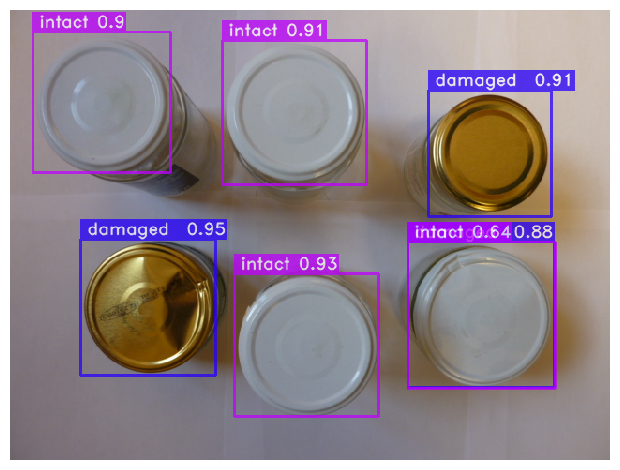

In [31]:
test_image = '/content/drive/MyDrive/yolonas/dataset/images/test/t1.JPG'
best_model.predict(test_image).show()

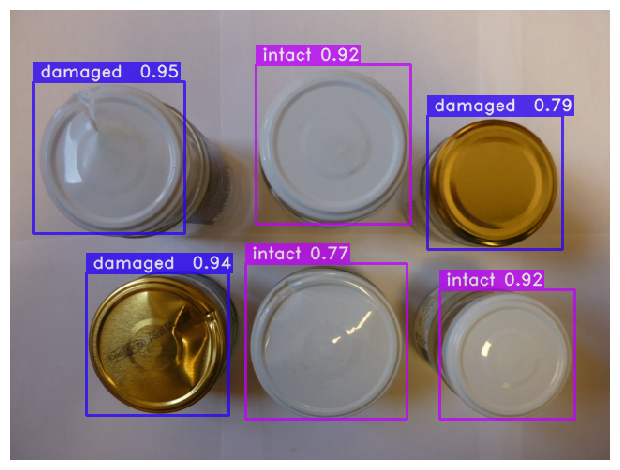

In [32]:
test_image = '/content/drive/MyDrive/yolonas/dataset/images/test/t2.JPG'
best_model.predict(test_image).show()

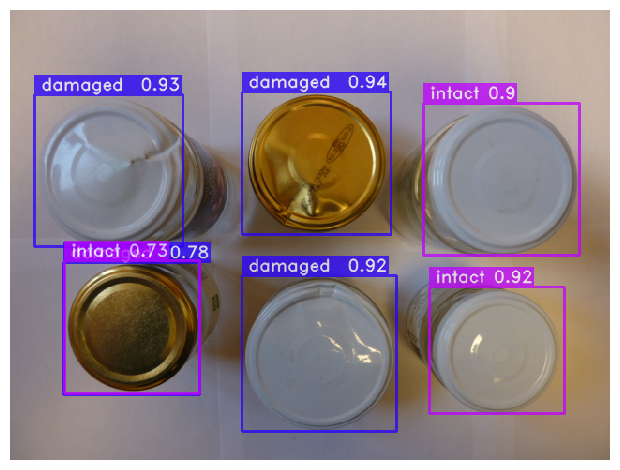

In [33]:
test_image = '/content/drive/MyDrive/yolonas/dataset/images/test/t3.JPG'
best_model.predict(test_image).show()

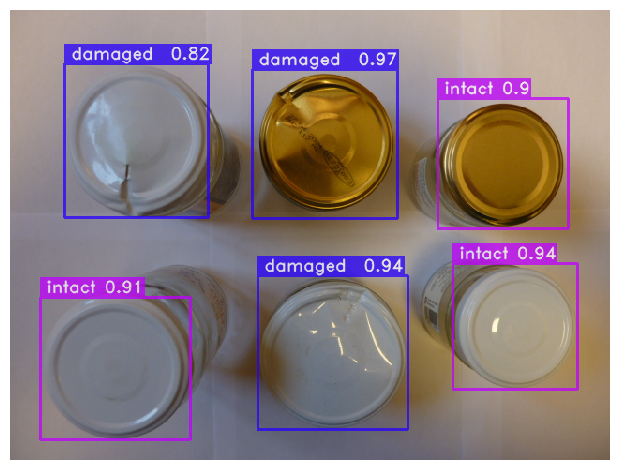

In [34]:
test_image = '/content/drive/MyDrive/yolonas/dataset/images/test/t4.JPG'
best_model.predict(test_image).show()

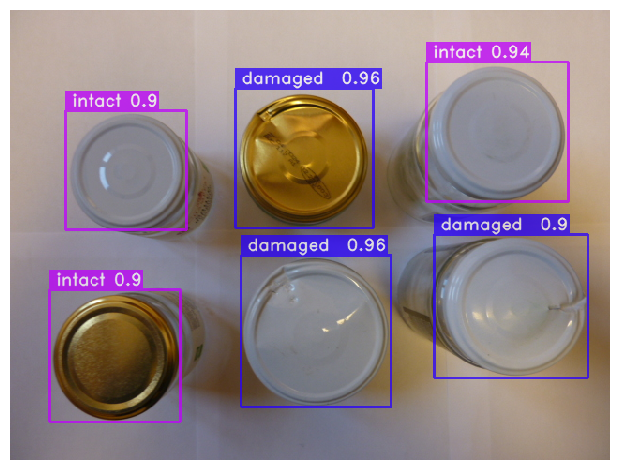

In [35]:
test_image = '/content/drive/MyDrive/yolonas/dataset/images/test/t5.JPG'
best_model.predict(test_image).show()